In [1]:
import networkx as nx 
from matplotlib import pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import networkx as nx
import torch
import copy
from torch.distributions.bernoulli import Bernoulli
import pandas as pd

from gsnn.models.GSNN import GSNN
from gsnn.models.NN import NN
from gsnn.simulate.nx2pyg import nx2pyg
from gsnn.simulate.datasets import simulate_3_in_3_out

from gsnn.optim.Environment import Environment
from gsnn.optim.RewardScaler import RewardScaler
from gsnn.models.GSNN import GSNN

from sklearn.metrics import roc_auc_score
from gsnn.optim.REINFORCE import REINFORCE
import argparse

from sklearn.metrics import confusion_matrix
import seaborn as sbn

# for reproducibility 
torch.manual_seed(0)
np.random.seed(0)

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/gsnn-mds/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Reinforcement learning for structure optimization

In many cases, prior knowledge is incomplete, noisy or spurrious for specific prediction tasks. In this example, we will demonstrate how we can use the reinforcement learning for the optimal selection of prior knowledge. 

NOTE: This procedure requires running many sequential training loops, and therefore is not applicable to large graphs or large datasets (where training time is significant). That said, RL's ability to identify true edges does offer a convenient evaluation of our premise that *the true graph structure should result in better performances than alternative graph structures*. 


Thoughts:   
In my experience playing with the RL parameters, it appears that this approach is specific but not sensitive to true edges. For instance, the true input edges are almost always included (across different hyper-params), but some false edges also may have high policy probabilities. This suggests that the model is robust to noisy edges (as long as the true edge is included), but also may limit the ability to identify the true graph. Including a nonzero policy decay (L1 regularization on policy probabilities), seems to help improve the sensitivity of true edges.   

Additionally, I've found that the "auc" (sum of all epoch test scores) reward type seens to be more resilient than "best" or "last", which may suggest that the true graph has advantages in early training, but less so in terms of late training or best test performance. 

It is also worth noting that the rewards are farily noisy (same action can result in a varied rewards), which may account for why the "best_action" is not always the true action (graph), whereas the policy is often a more robust metric of the true action. 

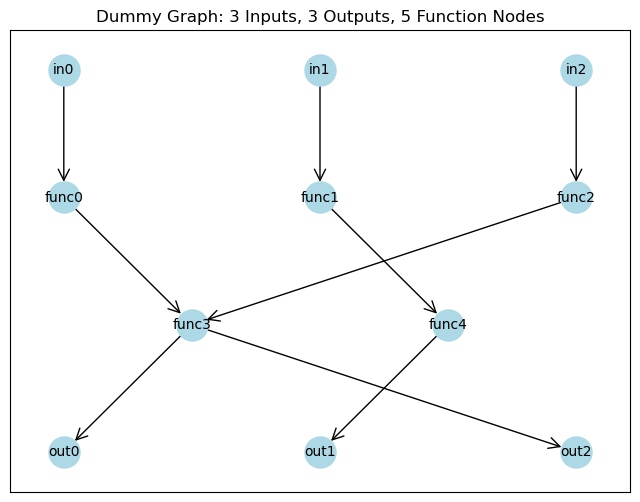

In [2]:
G, pos, x_train, x_test, y_train, y_test, \
    input_nodes, function_nodes, output_nodes = simulate_3_in_3_out(n_train=250, n_test=500,
                                                                    noise_scale=0.5, zscorey=True)

plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, arrowstyle='->', arrowsize=20)
plt.title("Dummy Graph: 3 Inputs, 3 Outputs, 5 Function Nodes")
plt.show()

In [3]:
data = nx2pyg(G, input_nodes, function_nodes, output_nodes) 

# add some false edges 
edge_index_dict = copy.deepcopy(data.edge_index_dict)

# add some false input edges 
edge_index_dict['input', 'to', 'function'] = torch.cat((edge_index_dict['input', 'to', 'function'], 
                                                         torch.tensor([[0, 1, 2, 1], 
                                                                       [1, 0, 1, 2]], 
                                                                       dtype=torch.long)), dim=-1) 



In [4]:
input_edges = set([(i.item(),j.item()) for i,j in data.edge_index_dict['input', 'to', 'function'].T])

action_label_dict = {}
action_label_dict[('input', 'to', 'function')] = [(i.item(), j.item()) in input_edges for i,j in edge_index_dict['input', 'to', 'function'].T] 

true_action = 1.*np.array(action_label_dict[('input', 'to', 'function')])

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataset = torch.utils.data.TensorDataset(x_train, y_train) 
test_dataset = torch.utils.data.TensorDataset(x_test, y_test) 

In [10]:
# GSNN model parameters
model_kwargs = {'edge_index_dict'                 : edge_index_dict, 
                    'node_names_dict'                 : data.node_names_dict,
                    'channels'                        : 25, 
                    'layers'                          : 3, 
                    'dropout'                         : 0.0,
                    'init'                            : 'degree_normalized',
                    'residual'                        : True,
                    'share_layers'                    : False,
                    'node_attn'                       : False,
                    'add_function_self_edges'         : True,
                    'norm'                            : 'batch'}

# GSNN training parameters
training_kwargs = {'lr':1e-3, 
                    'max_epochs':150, 
                    'batch':250,
                    'workers':1, 
                    'weight_decay':0}

# the action edge dict will be used to index the action for each edge 
# if and edge key is not provided, those values will not be optimized (always present)
action_edge_dict = {('input', 'to', 'function'): torch.arange(edge_index_dict['input', 'to', 'function'].shape[1])} 

n_actions = sum([torch.unique(v).numel() for v in action_edge_dict.values()])

env = Environment(action_edge_dict, train_dataset, test_dataset, model_kwargs, 
                 training_kwargs, metric='spearman', reward_type='auc', verbose=False,
                 raise_error_on_fail=True)


hoptim = REINFORCE(env, n_actions, action_labels=true_action, clip=10, eps=1e-8, warmup=3, verbose=True, 
                        entropy=0., entropy_decay=0.99, min_entropy=0.0, window=10,
                        init_prob=0.5, lr=1e-1, policy_decay=0.)

for iter in range(100): 
    hoptim.step()


	 --> iter: 1 || auroc 0.500 || acc: 0.571 || prob(true_action): 7.812E-03 || last reward: 32.588
	 --> iter: 2 || auroc 0.500 || acc: 0.571 || prob(true_action): 7.812E-03 || last reward: 53.619
	 --> iter: 3 || auroc 0.500 || acc: 0.571 || prob(true_action): 7.812E-03 || last reward: 65.064
	 --> iter: 4 || auroc 0.583 || acc: 0.571 || prob(true_action): 8.142E-03 || last reward: 58.687
	 --> iter: 5 || auroc 0.583 || acc: 0.571 || prob(true_action): 7.936E-03 || last reward: 30.957
	 --> iter: 6 || auroc 0.542 || acc: 0.429 || prob(true_action): 7.599E-03 || last reward: 65.096
	 --> iter: 7 || auroc 0.625 || acc: 0.571 || prob(true_action): 7.946E-03 || last reward: -1.738
	 --> iter: 8 || auroc 0.667 || acc: 0.714 || prob(true_action): 8.255E-03 || last reward: 35.345
	 --> iter: 9 || auroc 0.583 || acc: 0.714 || prob(true_action): 8.417E-03 || last reward: 69.432
	 --> iter: 10 || auroc 0.583 || acc: 0.714 || prob(true_action): 8.555E-03 || last reward: 56.540
	 --> iter: 11 || a

KeyboardInterrupt: 

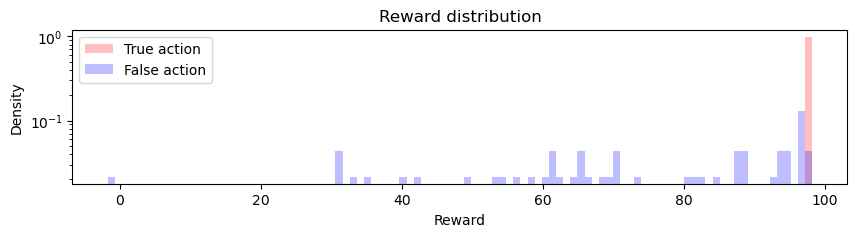

In [11]:
df = pd.DataFrame({'true_action':[(a == true_action).all() for a in hoptim.actions], 'reward':hoptim.rewards})
df = df.assign(rank=(-df['reward']).rank(method='first'))
df = df.assign(action = [x.tolist() for x in hoptim.actions])
_bins = np.linspace(min(df['reward']), max(df['reward']), 100)

plt.figure(figsize=(10,2)) 
plt.hist(df[lambda x: x.true_action]['reward'], color='r', alpha=0.25, label='True action', density=True, bins=_bins)
plt.hist(df[lambda x: ~x.true_action]['reward'], color='b', alpha=0.25, label='False action', density=True, bins=_bins)
plt.legend()
plt.title('Reward distribution')
plt.xlabel('Reward')
plt.ylabel('Density')
plt.yscale('log')
plt.show()

Was the true action tested/explored? True
	Rank of true action: 1.0
policy [0.8595649  0.88946974 0.78167015 0.7373407  0.62932104 0.22384267
 0.3806849 ]
best_action [1. 1. 1. 0. 0. 0. 0.]
true_action [1. 1. 1. 0. 0. 0. 0.]
best action accuracy: 1.000
final policy auroc: 1.000


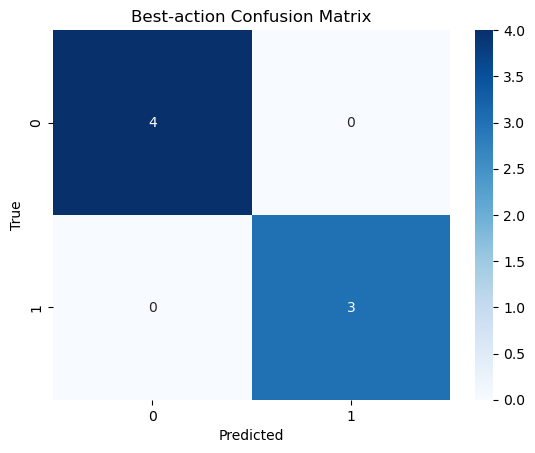

In [12]:
best_action = hoptim.best_action.detach().cpu().numpy().ravel()
policy = hoptim.logits.sigmoid().detach().cpu().numpy().ravel()

print('Was the true action tested/explored?', df.true_action.any())
if df.true_action.any(): print('\tRank of true action:', df[lambda x: x.true_action]['rank'].min())

print('policy', policy)
print('best_action', best_action)
print('true_action', true_action)

acc = np.mean(best_action == true_action)
auroc = roc_auc_score(true_action, policy)

print(f'best action accuracy: {acc:.3f}')
print(f'final policy auroc: {auroc:.3f}')

# plot  confusion matrix 
cm = confusion_matrix(true_action, best_action)

plt.figure() 
sbn.heatmap(cm, annot=True, fmt='d', cmap='Blues') 
plt.title('Best-action Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

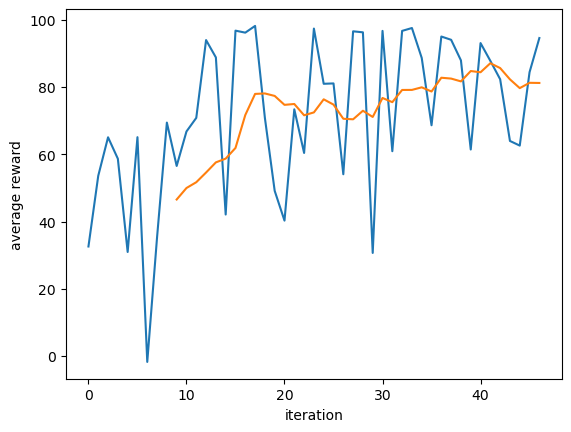

In [13]:
avg_reward = np.array(hoptim.rewards)
plt.figure() 
plt.plot(avg_reward)
plt.plot(pd.Series(avg_reward).rolling(window=10).mean())

plt.xlabel('iteration')
plt.ylabel('average reward')
plt.show()